In [30]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [31]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
train_path = "/kaggle/input/digit-recognizer/train.csv"
test_path = "/kaggle/input/digit-recognizer/test.csv"

In [33]:
train = pd.read_csv(train_path,dtype = np.float32)

In [34]:
print(f'The length of the data is {len(train)}')

The length of the data is 42000


In [35]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


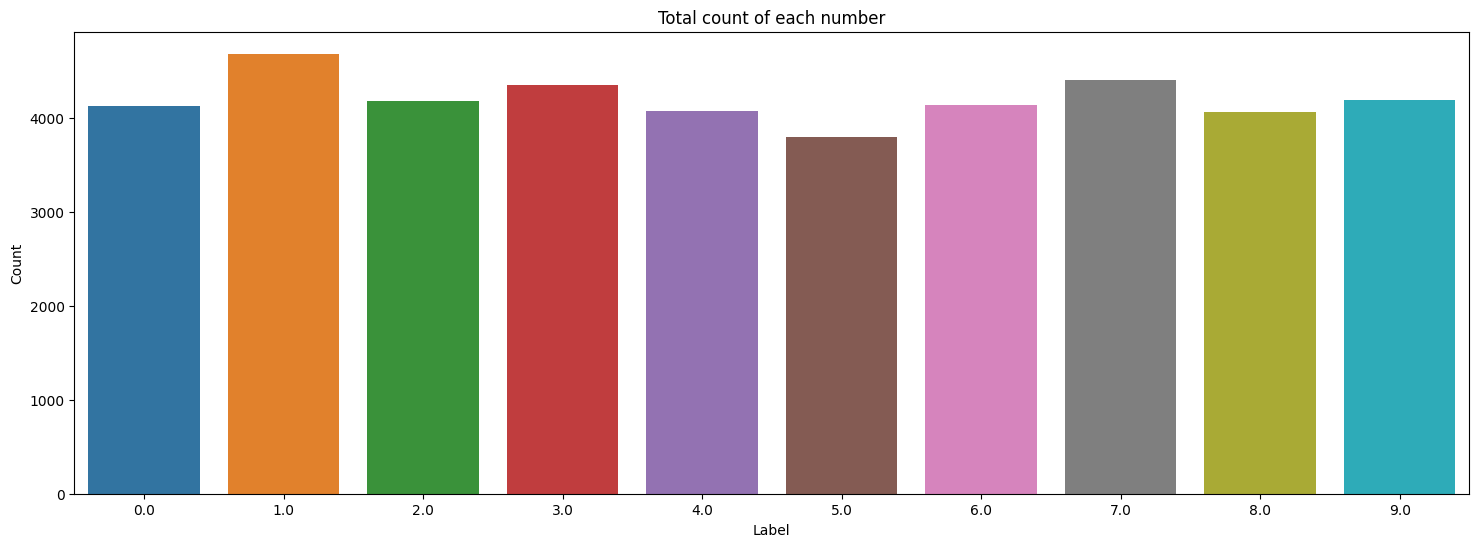

In [36]:
def plot_label_counts(dataframe):
    label_counts = dataframe['label'].value_counts().sort_index()
    plt.figure(figsize=(18, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title('Total count of each number')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()
plot_label_counts(train)

### Getting the dataset ready

In [38]:
from sklearn.model_selection import train_test_split

In [42]:
X = train.loc[:,train.columns != "label"].values/255
y = train.label.values

train_x, test_x, train_y, test_y = train_test_split(X,y,test_size = 0.2,random_state = 42)

train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y).type(torch.LongTensor) # data type is long

test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y).type(torch.LongTensor) # data type is long

#### Fitting a baseline model

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
#cuda if availabele 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
import torch
import torch.nn as nn


class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))  # Adjusted adaptive average pooling
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [27]:
model = VGG16()

In [28]:
from torchinfo import summary
summary(model=model,
        input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
VGG16                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─ReLU: 2-2                         [1, 64, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 64, 28, 28]           36,928
│    └─ReLU: 2-4                         [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-5                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-6                       [1, 128, 14, 14]          73,856
│    └─ReLU: 2-7                         [1, 128, 14, 14]          --
│    └─Conv2d: 2-8                       [1, 128, 14, 14]          147,584
│    └─ReLU: 2-9                         [1, 128, 14, 14]          --
│    └─MaxPool2d: 2-10                   [1, 128, 7, 7]            --
│    └─Conv2d: 2-11                      [1, 256, 7, 7]            295,

In [11]:
# Define the transformation pipeline
transform_one = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.1307, std=0.3081)
])
transform_one

Compose(
    ToTensor()
    Normalize(mean=0.1307, std=0.3081)
)